# tutorial https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

## Note to Jose
Working version but not fully understood yet
The next commented think can allow to remove stuff

In [1]:
# Download TorchVision repo to use some files from
# references/detection
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0
!pwd
!cp vision/references/detection/utils.py .
!cp vision/references/detection/transforms.py .
!cp vision/references/detection/coco_eval.py .
!cp vision/references/detection/engine.py .
!cp vision/references/detection/coco_utils.py .

fatal: destination path 'vision' already exists and is not an empty directory.
error: pathspec 'v0.3.0' did not match any file(s) known to git.
/home/jose/ros_ws/src/gr_perception/gr_ml/nb


In [2]:
import numpy as np
import torch
from PIL import Image


class PennFudanDataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [3]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [4]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

In [5]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model



In [6]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [7]:
import os
if False:
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)#.cuda()
    dataset = PennFudanDataset('/media/datasets/PennFundan/PennFudanPed',transforms=get_transform(train=True))
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=1, shuffle=True, num_workers=4,
        collate_fn=utils.collate_fn)

In [8]:
# For Testing Training
if False:
    images,targets = next(iter(data_loader))
    images = list(image for image in images)
    targets = [{k: v for k, v in t.items()} for t in targets]
    output = model(images,targets)   # Returns losses and detections
    # For inference
    model.eval()
    x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
    predictions = model(x)           # Returns predictions
    predictions


In [9]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = PennFudanDataset('/media/datasets/PennFundan/PennFudanPed', get_transform(train=True))

# split the dataset in train and test set
#indices = torch.randperm(int(len(dataset))).tolist()
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:25])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn)


dataset_test = PennFudanDataset('/media/datasets/PennFundan/PennFudanPed', get_transform(train=False))

dataset_test = torch.utils.data.Subset(dataset_test, indices[-3:])

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=2,
    collate_fn=utils.collate_fn)


# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")


Epoch: [0]  [ 0/25]  eta: 0:00:54  lr: 0.000213  loss: 5.4865 (5.4865)  loss_classifier: 0.8620 (0.8620)  loss_box_reg: 0.4024 (0.4024)  loss_mask: 4.1731 (4.1731)  loss_objectness: 0.0299 (0.0299)  loss_rpn_box_reg: 0.0190 (0.0190)  time: 2.1883  data: 0.0670  max mem: 1244
Epoch: [0]  [10/25]  eta: 0:00:16  lr: 0.002294  loss: 1.6636 (2.4387)  loss_classifier: 0.2919 (0.4597)  loss_box_reg: 0.1825 (0.2057)  loss_mask: 1.0648 (1.7326)  loss_objectness: 0.0248 (0.0303)  loss_rpn_box_reg: 0.0082 (0.0103)  time: 1.1155  data: 0.0078  max mem: 1650
Epoch: [0]  [20/25]  eta: 0:00:05  lr: 0.004376  loss: 0.6391 (1.4804)  loss_classifier: 0.1373 (0.2801)  loss_box_reg: 0.0982 (0.1474)  loss_mask: 0.3197 (1.0236)  loss_objectness: 0.0140 (0.0206)  loss_rpn_box_reg: 0.0053 (0.0086)  time: 0.9555  data: 0.0020  max mem: 1650
Epoch: [0]  [24/25]  eta: 0:00:01  lr: 0.005000  loss: 0.4682 (1.3429)  loss_classifier: 0.1028 (0.2482)  loss_box_reg: 0.0875 (0.1426)  loss_mask: 0.2805 (0.9247)  loss_ob

creating index...
index created!
Test:  [0/3]  eta: 0:00:01  model_time: 0.3060 (0.3060)  evaluator_time: 0.0058 (0.0058)  time: 0.3724  data: 0.0587  max mem: 1752
Test:  [2/3]  eta: 0:00:00  model_time: 0.3290 (0.3224)  evaluator_time: 0.0058 (0.0068)  time: 0.3508  data: 0.0205  max mem: 1752
Test: Total time: 0:00:01 (0.3567 s / it)
Averaged stats: model_time: 0.3290 (0.3224)  evaluator_time: 0.0058 (0.0068)
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.708
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.800
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDet

Epoch: [5]  [ 0/25]  eta: 0:00:22  lr: 0.000500  loss: 0.1268 (0.1268)  loss_classifier: 0.0074 (0.0074)  loss_box_reg: 0.0124 (0.0124)  loss_mask: 0.1057 (0.1057)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0012 (0.0012)  time: 0.9082  data: 0.0620  max mem: 1752
Epoch: [5]  [10/25]  eta: 0:00:15  lr: 0.000500  loss: 0.1378 (0.1773)  loss_classifier: 0.0206 (0.0255)  loss_box_reg: 0.0147 (0.0243)  loss_mask: 0.1171 (0.1210)  loss_objectness: 0.0005 (0.0009)  loss_rpn_box_reg: 0.0039 (0.0056)  time: 1.0191  data: 0.0075  max mem: 1752
Epoch: [5]  [20/25]  eta: 0:00:05  lr: 0.000500  loss: 0.1439 (0.1715)  loss_classifier: 0.0215 (0.0257)  loss_box_reg: 0.0147 (0.0231)  loss_mask: 0.1121 (0.1168)  loss_objectness: 0.0003 (0.0007)  loss_rpn_box_reg: 0.0036 (0.0053)  time: 1.0167  data: 0.0021  max mem: 1752
Epoch: [5]  [24/25]  eta: 0:00:01  lr: 0.000500  loss: 0.1673 (0.1909)  loss_classifier: 0.0255 (0.0299)  loss_box_reg: 0.0216 (0.0261)  loss_mask: 0.1182 (0.1287)  loss_ob

creating index...
index created!
Test:  [0/3]  eta: 0:00:01  model_time: 0.2846 (0.2846)  evaluator_time: 0.0033 (0.0033)  time: 0.3471  data: 0.0581  max mem: 1752
Test:  [2/3]  eta: 0:00:00  model_time: 0.3171 (0.3067)  evaluator_time: 0.0033 (0.0058)  time: 0.3334  data: 0.0201  max mem: 1752
Test: Total time: 0:00:01 (0.3391 s / it)
Averaged stats: model_time: 0.3171 (0.3067)  evaluator_time: 0.0033 (0.0058)
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.758
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.800
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDet

NameError: name 'd3' is not defined

In [10]:
del dataset
del data_loader

In [11]:
# pick one image from the test set
img, img2 = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

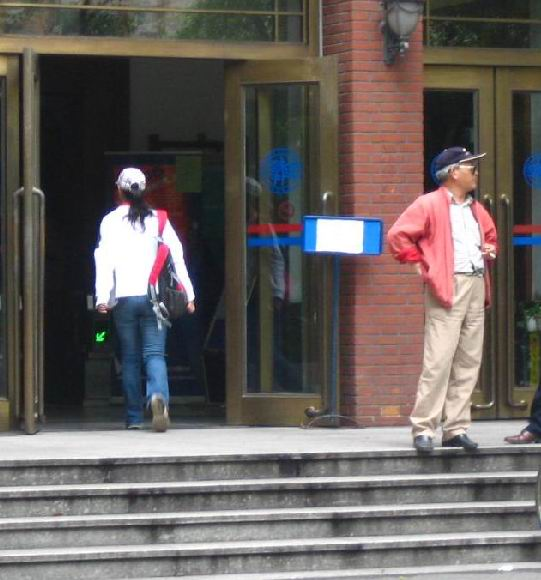

In [12]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

dict_keys(['boxes', 'labels', 'masks', 'image_id', 'area', 'iscrowd'])
tensor([[ 93., 168., 194., 431.],
        [388., 149., 498., 452.]])
load
load
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] [  0 255] (580, 541) <class 'numpy.ndarray'>


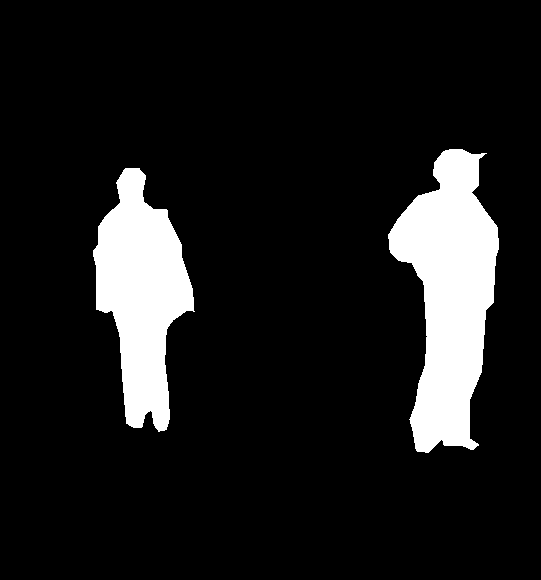

In [13]:
print(img2.keys())
print(img2['boxes'])
mshape = img2['masks'].shape
arr = np.zeros((mshape[1],mshape[2]),dtype=np.uint8)
for i in range(mshape[0]):
    print ("load")
    arr += img2['masks'][i].mul(255).byte().numpy()
print (arr, np.unique(arr), arr.shape, type(arr))
image = Image.fromarray(arr)
image

In [14]:
def get_rect(x, y, width, height):
    rect = [(x, y), (x+width, y), (x+width, y+height), (x, y+height), (x, y)]
    #rect = [(0, 0), (width, height)]
    
    return tuple(rect)

torch.Size([2, 1, 580, 541])
(541, 580)
(541, 580)


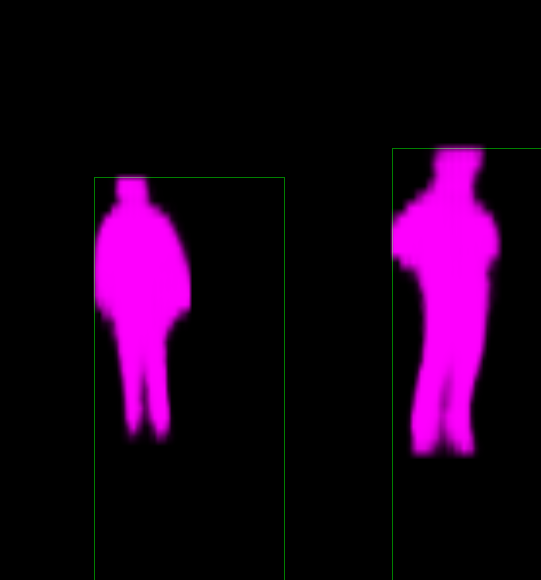

In [15]:
from PIL import ImageDraw
pshape = prediction[0]['masks'].shape
boxes = prediction[0]['boxes'].cpu().numpy()
print(prediction[0]['masks'].shape)

arr = np.zeros((pshape[2],pshape[3]),dtype=np.uint8)
for i in range(pshape[0]):
    arr += prediction[0]['masks'][i,0].mul(255).byte().cpu().numpy()
image = Image.fromarray(arr)


overlay = Image.new("L", (pshape[3], pshape[2]), 0)
draw = ImageDraw.Draw(overlay)
rects = [get_rect(*p) for p in boxes]

for rect in rects:
    draw.line([tuple(p) for p in rect], width=1, fill=127)


print(image.size)
print(overlay.size)

img = Image.merge("RGB", (image,overlay,image))
(image,overlay)
img